In [1]:
import numpy as np
from numpy import asarray
import pandas as pd
from matplotlib import image
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from sklearn.model_selection import train_test_split
from skimage import io, transform

import PIL
from PIL import Image
import cv2
import random
import time
import copy

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip gdrive/MyDrive/Artwork.zip

Streaming output truncated to the last 5000 lines.
  inflating: Artwork/Paul_Gauguin/Paul_Gauguin_95.jpg  
  inflating: __MACOSX/Artwork/Paul_Gauguin/._Paul_Gauguin_95.jpg  
  inflating: Artwork/Paul_Gauguin/Paul_Gauguin_81.jpg  
  inflating: __MACOSX/Artwork/Paul_Gauguin/._Paul_Gauguin_81.jpg  
  inflating: Artwork/Paul_Gauguin/Paul_Gauguin_56.jpg  
  inflating: __MACOSX/Artwork/Paul_Gauguin/._Paul_Gauguin_56.jpg  
  inflating: Artwork/Paul_Gauguin/Paul_Gauguin_42.jpg  
  inflating: __MACOSX/Artwork/Paul_Gauguin/._Paul_Gauguin_42.jpg  
  inflating: Artwork/Paul_Gauguin/Paul_Gauguin_108.jpg  
  inflating: __MACOSX/Artwork/Paul_Gauguin/._Paul_Gauguin_108.jpg  
  inflating: Artwork/Paul_Gauguin/Paul_Gauguin_134.jpg  
  inflating: __MACOSX/Artwork/Paul_Gauguin/._Paul_Gauguin_134.jpg  
  inflating: Artwork/Paul_Gauguin/Paul_Gauguin_120.jpg  
  inflating: __MACOSX/Artwork/Paul_Gauguin/._Paul_Gauguin_120.jpg  
  inflating: Artwork/Paul_Gauguin/Paul_Gauguin_121.jpg  
  inflating: __MACOSX/Art

In [4]:
artists = pd.read_csv('gdrive/MyDrive/artists.csv')
artists.drop(artists[artists['paintings']<200].index, inplace=True)
artists.sort_values(by="name", inplace = True)
artists.drop(columns=["years", "nationality", "bio", "wikipedia"], inplace=True)
artists["id"] = range(0,11)
artists.reset_index(drop=True, inplace=True)
artists.replace('\s+', '_',regex=True,inplace=True)
artists.columns=["ID", "Name", "Genre", "Paintings"]
artists["Name"].replace("Albrecht_Dürer", "Albrecht_Durer", inplace=True)
artists

,ID,Name,Genre,Paintings
0,0,Albrecht_Durer,Northern_Renaissance,328
1,1,Alfred_Sisley,Impressionism,259
2,2,Edgar_Degas,Impressionism,702
3,3,Francisco_Goya,Romanticism,291
4,4,Marc_Chagall,Primitivism,239
5,5,Pablo_Picasso,Cubism,439
6,6,Paul_Gauguin,"Symbolism,Post-Impressionism",311
7,7,Pierre-Auguste_Renoir,Impressionism,336
8,8,Rembrandt,Baroque,262
9,9,Titian,"High_Renaissance,Mannerism",255


In [5]:
file = 'Artwork'
artwork = pd.DataFrame(columns=["Artist", "Path"])
for file_path in os.listdir(file):
            path = os.path.join(file, file_path)
            if os.path.isdir(path):
                for image_path in os.listdir(path):
                    input_path = os.path.join(path, image_path)
                    name = artists[artists.Name == os.path.basename(path)].ID
                    name.reset_index(drop=True, inplace=True)
                    artwork = artwork.append(pd.Series({"Artist": name[0], 
                                                        "Path": input_path}), 
                                             ignore_index=True)


In [6]:
imgs = []
for i in range (4299):
    im = Image.open(artwork.iloc[i].Path)
    im = asarray(im)
    if (len(im.shape)!=3 or im.shape[2]!=3):
        imgs.append(i)
artwork.drop(imgs, inplace=True)
artwork.reset_index(drop=True, inplace=True)

In [7]:
artwork

,Artist,Path
0,4,Artwork/Marc_Chagall/Marc_Chagall_96.jpg
1,4,Artwork/Marc_Chagall/Marc_Chagall_121.jpg
2,4,Artwork/Marc_Chagall/Marc_Chagall_196.jpg
3,4,Artwork/Marc_Chagall/Marc_Chagall_187.jpg
4,4,Artwork/Marc_Chagall/Marc_Chagall_61.jpg
...,...,...
4227,10,Artwork/Vincent_van_Gogh/Vincent_van_Gogh_744.jpg
4228,10,Artwork/Vincent_van_Gogh/Vincent_van_Gogh_794.jpg
4229,10,Artwork/Vincent_van_Gogh/Vincent_van_Gogh_676.jpg
4230,10,Artwork/Vincent_van_Gogh/Vincent_van_Gogh_415.jpg


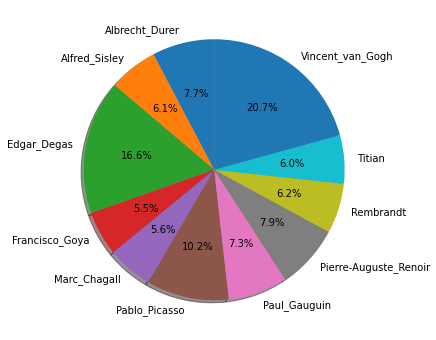

In [8]:
x = artists.Name.unique()
plt.figure(figsize = (6,6))
plt.pie(artwork.groupby('Artist').size(), labels = x, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

In [9]:
class Artwork(Dataset):
    def __init__(self, df, transforms=None):
        
        self.transforms = transforms
        self.df = df
                    
    def __len__(self):
        # return len(paintings.df)
        return len(self.df)
    
    def get_sample(self, idx):
        info = self.df.iloc[idx]
        im = Image.open(info["Path"])
        im = asarray(im)
        return (info["Artist"], im)
    
    def __getitem__(self, idx):
        artist, img = self.get_sample(idx)
        if self.transforms:
            img = self.transforms(img)
        means = img.mean([1,2])
        std = img.std([1,2])
        x = (artist, transforms.Normalize(means, std)(img))
        return x        

In [10]:
composed = transforms.Compose([transforms.ToTensor(), transforms.Resize(256), 
                               transforms.RandomCrop(256), 
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.RandomVerticalFlip(p=0.5)])

paintings = Artwork(artwork, transforms=composed)
paintings.df.head()

,Artist,Path
0,4,Artwork/Marc_Chagall/Marc_Chagall_96.jpg
1,4,Artwork/Marc_Chagall/Marc_Chagall_121.jpg
2,4,Artwork/Marc_Chagall/Marc_Chagall_196.jpg
3,4,Artwork/Marc_Chagall/Marc_Chagall_187.jpg
4,4,Artwork/Marc_Chagall/Marc_Chagall_61.jpg


In [11]:
img = paintings.__getitem__(random.randint(0, 4298))
print(img[0], img[1].shape)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


2 torch.Size([3, 256, 256])


torch.Size([3, 1469, 2228])
torch.Size([3, 256, 388])
torch.Size([3, 256, 256])


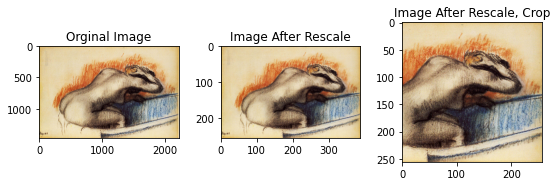

In [12]:
img = paintings.get_sample(random.randint(0, 4298))
img = transforms.ToTensor()(img[1])
img_rscl = transforms.Resize(256)(img)
img_crop = transforms.RandomCrop(256)(img_rscl)

fig = plt.figure(figsize=(9,9))
plt.subplots_adjust(wspace = 0.3)
                    
ax = plt.subplot(1, 3, 1)
ax.set_title("Orginal Image")
plt.imshow(img.permute(1, 2, 0))
print(img.shape)

ax = plt.subplot(1, 3, 2)
ax.set_title("Image After Rescale")
plt.imshow(img_rscl.permute(1, 2, 0))
print(img_rscl.shape)

ax = plt.subplot(1, 3, 3)
ax.set_title("Image After Rescale, Crop")
plt.imshow(img_crop.permute(1, 2, 0))
print(img_crop.shape)
    
plt.show()

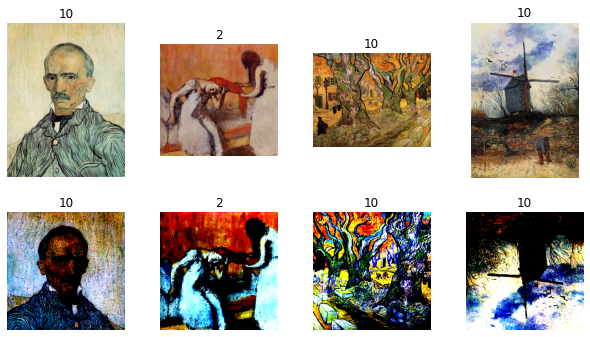

In [14]:
fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left = 0.1, wspace = 0.3, hspace=0.1)

for i in range(4):
    ax = plt.subplot(2, 4, i + 1)
    idx = random.randint(0, 4298)
    sample = paintings.get_sample(idx)
    ax.set_title(sample[0])
    ax.axis('off')
    plt.imshow(sample[1])
    
    ax = plt.subplot(2, 4, i + 5)
    transformed = paintings.__getitem__(idx)
    ax.set_title(transformed[0])
    ax.axis('off')
    img = np.clip(transformed[1], 0, 1)
    plt.imshow(img.permute(1, 2, 0))
    #plt.imshow(transformed[1].permute(1, 2, 0), vmin= transformed[1].min(), 
               #vmax=transformed[1].max())
    
plt.show()

In [16]:
train, test = train_test_split(artwork, test_size=0.2, stratify=artwork.Artist)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [17]:
train

,Artist,Path
0,5,Artwork/Pablo_Picasso/Pablo_Picasso_348.jpg
1,1,Artwork/Alfred_Sisley/Alfred_Sisley_208.jpg
2,9,Artwork/Titian/Titian_132.jpg
3,0,Artwork/Albrecht_Durer/Albrecht_Dürer_230.jpg
4,10,Artwork/Vincent_van_Gogh/Vincent_van_Gogh_639.jpg
...,...,...
3380,10,Artwork/Vincent_van_Gogh/Vincent_van_Gogh_445.jpg
3381,10,Artwork/Vincent_van_Gogh/Vincent_van_Gogh_268.jpg
3382,10,Artwork/Vincent_van_Gogh/Vincent_van_Gogh_58.jpg
3383,10,Artwork/Vincent_van_Gogh/Vincent_van_Gogh_784.jpg


In [18]:
test

,Artist,Path
0,10,Artwork/Vincent_van_Gogh/Vincent_van_Gogh_10.jpg
1,6,Artwork/Paul_Gauguin/Paul_Gauguin_144.jpg
2,10,Artwork/Vincent_van_Gogh/Vincent_van_Gogh_740.jpg
3,10,Artwork/Vincent_van_Gogh/Vincent_van_Gogh_645.jpg
4,0,Artwork/Albrecht_Durer/Albrecht_Dürer_42.jpg
...,...,...
842,4,Artwork/Marc_Chagall/Marc_Chagall_193.jpg
843,2,Artwork/Edgar_Degas/Edgar_Degas_449.jpg
844,9,Artwork/Titian/Titian_165.jpg
845,1,Artwork/Alfred_Sisley/Alfred_Sisley_4.jpg


In [19]:
train_dataset = Artwork(train, transforms=composed)
val_dataset = Artwork(test, transforms=composed)

train_loader = DataLoader(train_dataset, batch_size=50)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

dataloaders = {'train':train_loader, 'val':val_loader}
dataset_sizes = {'train': len(train), 'val':len(test)}

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch: " + str(epoch+1) + "/" + str(num_epochs))
        print("-" * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for labels, inputs in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                # print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                #     phase, epoch_loss, epoch_acc))

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        print()
      

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model
        
    

In [26]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 11)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [27]:
model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                    num_epochs=25)

Epoch: 1/25
----------
train Loss: 2.6549 Acc: 0.1799
val Loss: 2.5040 Acc: 0.1960

Epoch: 2/25
----------
train Loss: 2.5095 Acc: 0.1849
val Loss: 2.5852 Acc: 0.1936

Epoch: 3/25
----------
train Loss: 2.5314 Acc: 0.1870
val Loss: 2.5306 Acc: 0.1889

Epoch: 4/25
----------
train Loss: 2.5176 Acc: 0.1835
val Loss: 2.5062 Acc: 0.1865

Epoch: 5/25
----------
train Loss: 2.5387 Acc: 0.1835
val Loss: 2.5153 Acc: 0.1889

Epoch: 6/25
----------
train Loss: 2.5182 Acc: 0.1864
val Loss: 2.5077 Acc: 0.1842

Epoch: 7/25
----------
train Loss: 2.5053 Acc: 0.1867
val Loss: 2.5558 Acc: 0.1924

Epoch: 8/25
----------
train Loss: 2.5285 Acc: 0.1829
val Loss: 2.4891 Acc: 0.1889

Epoch: 9/25
----------
train Loss: 2.5317 Acc: 0.1838
val Loss: 2.5626 Acc: 0.1913

Epoch: 10/25
----------
train Loss: 2.5160 Acc: 0.1849
val Loss: 2.5279 Acc: 0.1924

Epoch: 11/25
----------
train Loss: 2.5306 Acc: 0.1838
val Loss: 2.4868 Acc: 0.1889

Epoch: 12/25
----------
train Loss: 2.5251 Acc: 0.1864
val Loss: 2.5055 Ac